In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from IPython.display import Image, display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, MaxPool2D, Conv2D, Input, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model
import platform
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [9]:
# !git clone https://github.com/CptJarkov/MLProj.git

fatal: destination path 'MLProj' already exists and is not an empty directory.


In [2]:
data=pd.read_csv('labels.csv')
data['pth'] = data['pth'].astype(str)

In [3]:
data

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


In [4]:
def image_show(i):
    row = data.iloc[i]
    pth = row[1]
    image_path = pth
    img = mpimg.imread(image_path)
    return img, row[2]

C:\Users\Kamil\AppData\Local\Temp\ipykernel_5480\2630951677.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pth = row[1]
C:\Users\Kamil\AppData\Local\Temp\ipykernel_5480\2630951677.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return img, row[2]


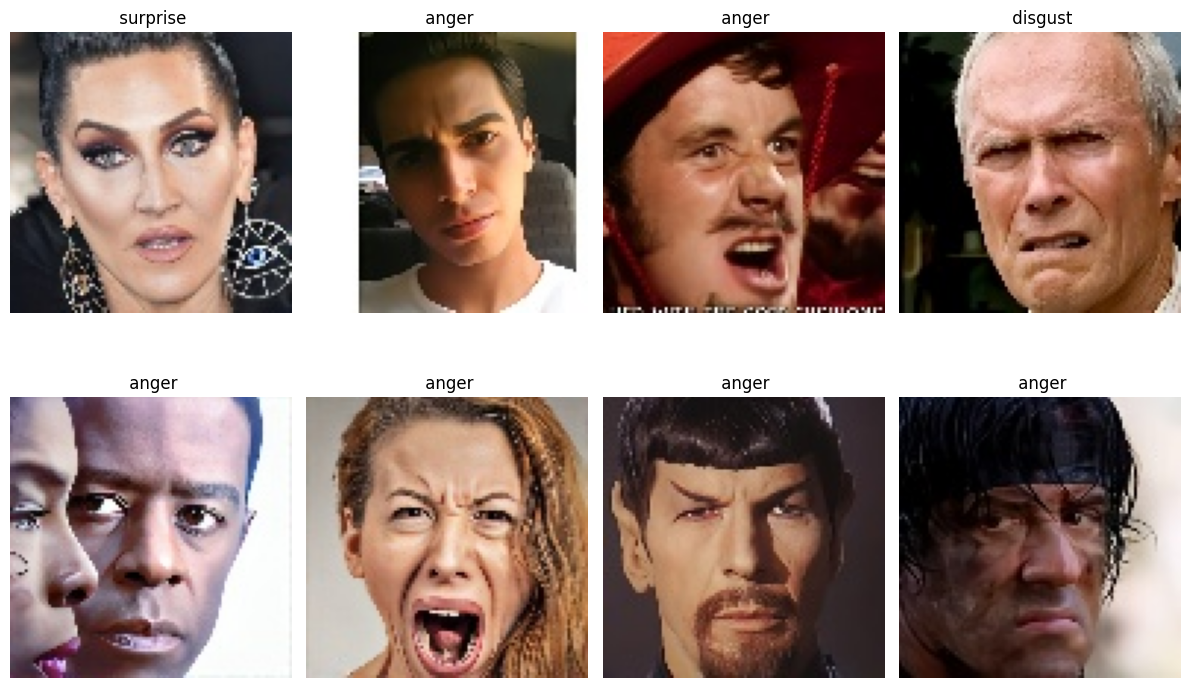

In [5]:

i = 8
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title = image_show(i)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f' {title}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Wyciąganie ścieżek i etykiet
X = data['pth'].values
y = data['label'].values

In [7]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    #Zmiana skali szarości
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Przeskalowywanie obrazów na 96*96 pixel
    img_resized = cv2.resize(img_gray, (96, 96))
    #Normalizacja pixeli
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Etykietowanie danych
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))

In [8]:
# Wyciąganie ścieżek i etykiet z tabeli
X = data['pth'].to_numpy()
y = data['label'].to_numpy()

In [9]:
# Podział danych zbiór testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y)

In [10]:
input_shape=X_preprocessed[0].shape

input_shape

(96, 96)

In [11]:
label_mapping={0: 'zly',
 1: 'pogardliwy',
 2: 'zniesmaczony',
 3: 'przerazony',
 4: 'szczesliwy',
 5: 'neutralny',
 6: 'smutny',
 7: 'zaskoczony'}

In [12]:

input_shape = (96, 96, 1) # Dla obrazów w skali szarości użyj (96, 96, 1)

model = Sequential()

model.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape)) # Warstwa konwolucyjna; wyodrębnia cechy z obrazów
model.add(BatchNormalization()) # Normalizacja; normalizuje dane wejściowe, przyspiesza trening i stabilizuje proces uczenia
model.add(MaxPool2D(pool_size=(2,2))) # MaxPooling; redukuje wymiarowość
model.add(Dropout(0.25)) # Dropout; regularyzacja, losowo wyłącza część neuronów w trakcie treningu


model.add(Conv2D(64, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="selu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Flatten; Spłaszczenie danych wejściowych do jednowymiarowego wektora
model.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01))) # Dense; Warstwa w pełni połączona, która wykonuje klasyfikację na podstawie wyodrębnionych cech
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax')) # Softmax; funkcja aktywacji w warstwie wyjściowej dla klasyfikacji wieloklasowej, zwraca prawdopodobieństwo dla każdej klasy

model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Kamil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,373,704 (12.87 MB)

 Trainable params: 3,372,744 (12.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
 history = model.fit(X_train, y_train, batch_size=64,
                      epochs=20,
                      validation_data=(X_test, y_test),
                      callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')],
                      verbose=1)

model.save('final_model.keras')

Epoch 1/20
353/353 [==============================] - 16s 45ms/step - loss: 1.4311 - accuracy: 0.6444 - val_loss: 1.4290 - val_accuracy: 0.6245 - lr: 1.0000e-04
Epoch 2/20
353/353 [==============================] - 15s 44ms/step - loss: 1.3114 - accuracy: 0.6678 - val_loss: 1.4192 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 3/20
353/353 [==============================] - 15s 43ms/step - loss: 1.2461 - accuracy: 0.6841 - val_loss: 1.3807 - val_accuracy: 0.6335 - lr: 1.0000e-04
Epoch 4/20
353/353 [==============================] - 15s 42ms/step - loss: 1.2081 - accuracy: 0.6986 - val_loss: 1.4085 - val_accuracy: 0.6243 - lr: 1.0000e-04
Epoch 5/20
353/353 [==============================] - ETA: 0s - loss: 1.1750 - accuracy: 0.7138
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
353/353 [==============================] - 15s 43ms/step - loss: 1.1750 - accuracy: 0.7138 - val_loss: 1.3982 - val_accuracy: 0.6302 - lr: 1.0000e-04
Epoch 6/20
353/353 [=============

In [12]:
# Load the model
model = tf.keras.models.load_model('my_model.h5')
model.load_weights('model_weights.h5')
# Compile the loaded model to set up the metrics
print("Model loaded and compiled successfully!")

c:\Users\Kamil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model loaded and compiled successfully!


In [25]:
pd.DataFrame(history.history).plot()

NameError: name 'history' is not defined

177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step
          Label  Precision    Recall  F1-score       AUC
0           zly   0.666176  0.627424  0.646220  0.930957
1    pogardliwy   0.625344  0.699538  0.660364  0.945467
2  zniesmaczony   0.593530  0.608069  0.600712  0.904592
3    przerazony   0.744578  0.507389  0.603516  0.934736
4    szczesliwy   0.830752  0.866205  0.848108  0.984921
5     neutralny   0.505747  0.538462  0.521592  0.907512
6        smutny   0.605691  0.497496  0.546288  0.916577
7    zaskoczony   0.640255  0.761647  0.695695  0.936286
8       Overall   0.651509  0.638279  0.640312  0.931964


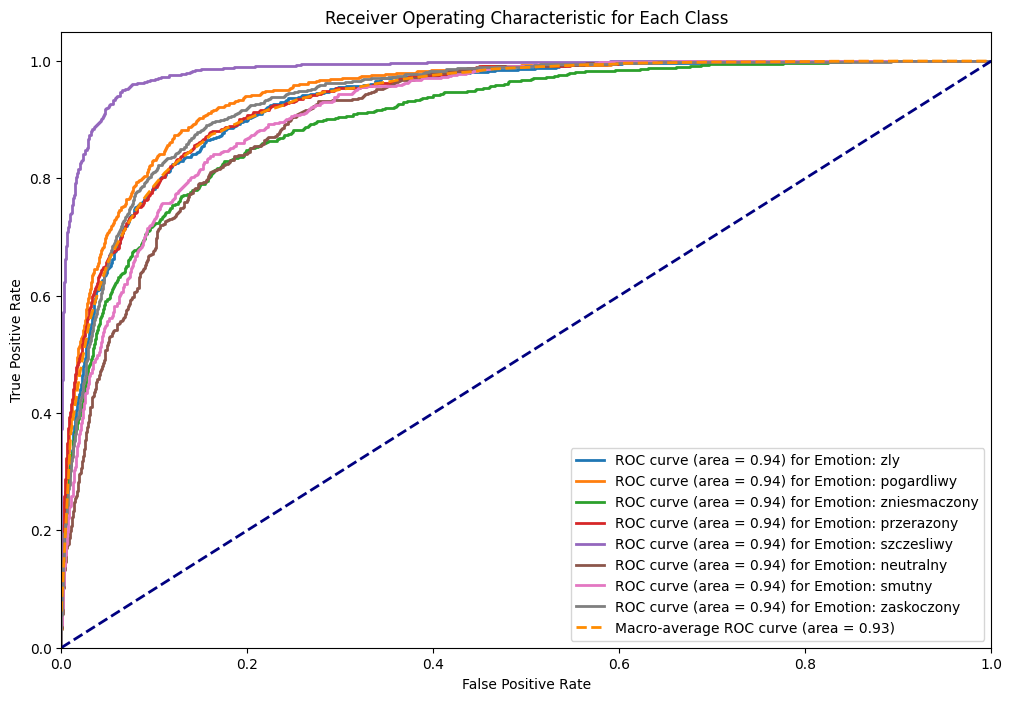

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

y_pred_prob=model.predict(X_test)
# Zamiana prawdopodobieństw na binarne predykcje
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Zamiana y_test na binarne etykiety
y_true_labels = np.argmax(y_test, axis=1)

# Lista składująca indywidualne wartości precision, recall i F1-score dla każdej klasy
class_metrics = []

# Lista składująca indywidualne wartości AUC i krzywej ROC dla każdej klasy
roc_curves = []


for i in range(8):
    # Zamiana przewidzianych i faktycznych etykiet do binarnych etykiet
    y_pred_binary = (y_pred_labels == i)
    y_true_binary = (y_true_labels == i)

    # Obliczanie precyzji, czułości i F1-score
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)

    # Obliczanie krzywej ROC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, label_mapping[i]))

    # Składowanie metryk
    class_metrics.append({
        'Label': label_mapping[i],
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc
    })



# Kompilowanie krzywej ROC
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
macro_auc = auc(mean_fpr, mean_tpr)




# Obliczanie całkowitej precyzji, czułości i F1-score
overall_precision = precision_score(y_true_labels, y_pred_labels, average='macro')
overall_recall = recall_score(y_true_labels, y_pred_labels, average='macro')
overall_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

class_metrics.append({
    'Label': 'Overall',
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1-score': overall_f1,
    'AUC': macro_auc
})


# Tworzenie ramki danych metryk
metrics_df = pd.DataFrame(class_metrics)

# Opcjonalne wyświetlanie ramki danych metryk
print(metrics_df)


# Wyświetlanie krzywych ROC dla każdej klasy
plt.figure(figsize=(12, 8))
lw = 2


for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = {:.2f}) for Emotion: {}'.format(roc_auc, label))

plt.plot(mean_fpr, mean_tpr, color='darkorange', linestyle='--', linewidth=2, label='Macro-average ROC curve (area = {:.2f})'.format(macro_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc='lower right')
plt.show()


In [14]:
mismatch_index=[]
for i in range(0,len(y_true_labels)):
    if y_true_labels[i]!=y_pred_labels[i]:
        mismatch_index.append(i)

In [15]:
def pred_vs_actual_label(i):
    i=mismatch_index[i]
    img_array=X_test[i]
    img_array = (img_array * 255).astype(np.uint8)
    pred_label=label_mapping[y_pred_labels[i]]
    actual_label=label_mapping[y_true_labels[i]]
    return img_array,pred_label,actual_label

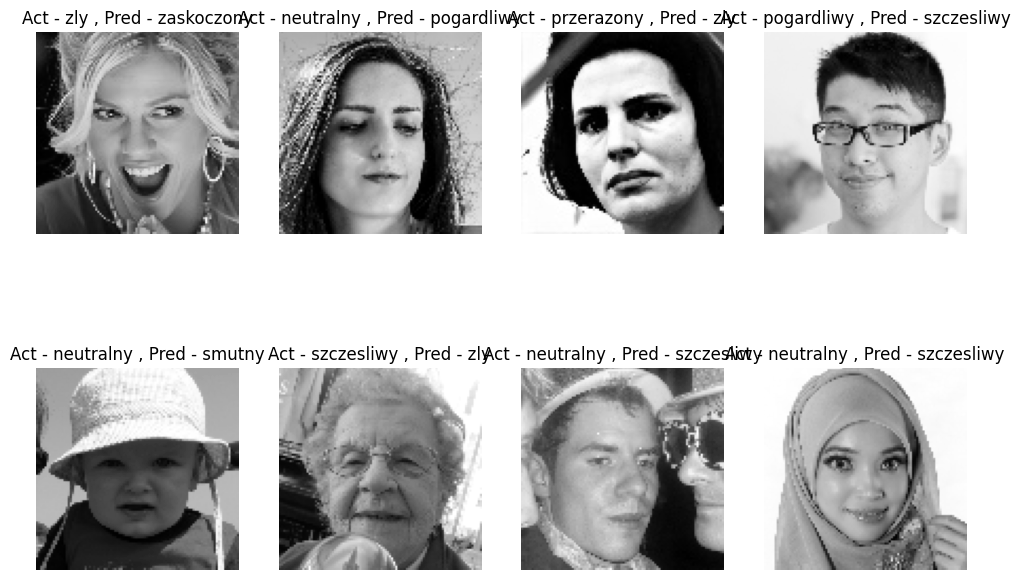

In [16]:
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_array,pred_label,actual_label=pred_vs_actual_label(i)

    axes[row, col].imshow(img_array,cmap= 'gray')
    axes[row, col].set_title(f"Act - {actual_label}"+" , "+f"Pred - {pred_label}")
    axes[row, col].axis('off')

In [17]:
match_index = [i for i in range(len(y_true_labels)) if y_true_labels[i] == y_pred_labels[i]]

In [18]:
def pred_vs_actual_label_good(i):
    idx = match_index[i]
    img_array = X_test[idx]
    img_array = (img_array * 255).astype(np.uint8)
    pred_label = label_mapping[y_pred_labels[idx]]
    actual_label = label_mapping[y_true_labels[idx]]
    return img_array, pred_label, actual_label

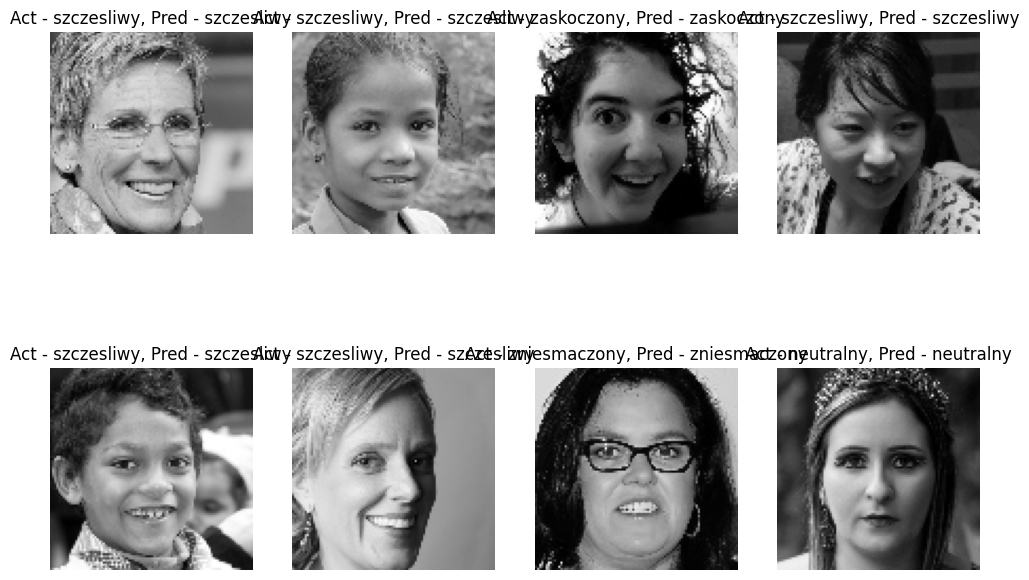

In [19]:
import matplotlib.pyplot as plt

i = 8
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx in range(i):
    row = idx // num_cols
    col = idx % num_cols
    img_array, pred_label, actual_label = pred_vs_actual_label_good(idx)
    axes[row, col].imshow(img_array,cmap= 'gray')
    axes[row, col].set_title(f"Act - {actual_label}, Pred - {pred_label}")
    axes[row, col].axis('off')

plt.show()

177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step


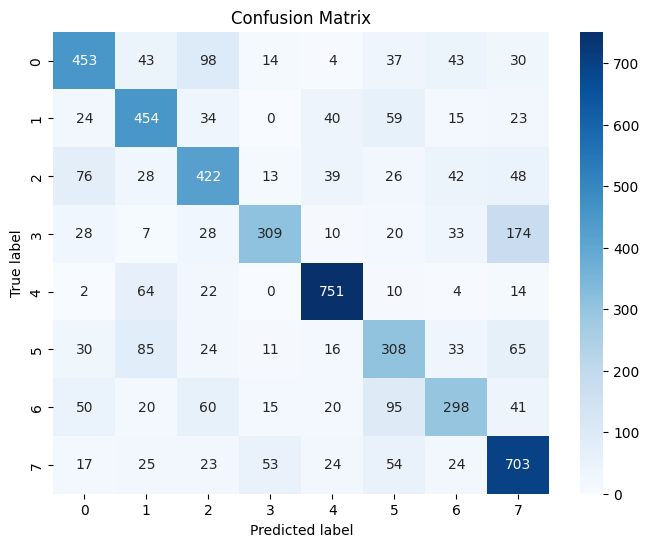

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels back to categorical

# Obliczanie macierzy pomyłek
cm = confusion_matrix(y_true, y_pred)

# Wyświetlanie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [21]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(img):
    face_img = img.copy()
    face_rec = face_cascade.detectMultiScale(face_img)

    if len(face_rec) == 0:
        return face_img, None, None, None
    
    for (x, y, w, h) in face_rec:
        cv2.rectangle(face_img, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=4)
        face = face_img[y:y + h, x:x + w]
        return face_img, face, x, y

    return face_img, None, None, None

In [24]:
cap = cv2.VideoCapture(0)

while True:
    ret,frame = cap.read()
    frame,face, x, y = detect_face(frame)

    if x == None or y == None:
        cv2.imshow('Video face detect',frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
    else:
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face_for_model = cv2.resize(face,(96,96))
        face_for_model = face_for_model / 255.0
        face_for_model = np.expand_dims(face_for_model, axis=0)  # Now shape is (1, 96, 96)
        face_for_model = face_for_model.astype('float32')

        predicted_face = model.predict(face_for_model)
        right_face = np.argmax(predicted_face, axis = 1)
        right_face_label = right_face[0]

 
        cv2.putText(frame,text=label_mapping[right_face_label],org = (x-15,y-15),fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 1/2, color = (0,0,255),thickness = 2 )
     
        cv2.imshow('Video face detect',frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━